# Temperature Forecast Project

### Problem Statement:

**Data Set Information:**

This data is for the purpose of bias correction of next-day maximum and minimum air temperatures forecast of the LDAPS model operated by the Korea Meteorological Administration over Seoul, South Korea. This data consists of summer data from 2013 to 2017. The input data is largely composed of the LDAPS model's next-day forecast data, in-situ maximum and minimum temperatures of present-day, and geographic auxiliary variables. There are two outputs (i.e. next-day maximum and minimum air temperatures) in this data. Hindcast validation was conducted for the period from 2015 to 2017.


**Attribute Information:**

_For more information, read [Cho et al, 2020]._
1. station - used weather station number: 1 to 25
2. Date - Present day: yyyy-mm-dd ('2013-06-30' to '2017-08-30')
3. Present_Tmax - Maximum air temperature between 0 and 21 h on the present day (Â°C): 20 to 37.6
4. Present_Tmin - Minimum air temperature between 0 and 21 h on the present day (Â°C): 11.3 to 29.9
5. LDAPS_RHmin - LDAPS model forecast of next-day minimum relative humidity (%): 19.8 to 98.5
6. LDAPS_RHmax - LDAPS model forecast of next-day maximum relative humidity (%): 58.9 to 100
7. LDAPS_Tmax_lapse - LDAPS model forecast of next-day maximum air temperature applied lapse rate (Â°C): 17.6 to 38.5
8. LDAPS_Tmin_lapse - LDAPS model forecast of next-day minimum air temperature applied lapse rate (Â°C): 14.3 to 29.6
9. LDAPS_WS - LDAPS model forecast of next-day average wind speed (m/s): 2.9 to 21.9
10. LDAPS_LH - LDAPS model forecast of next-day average latent heat flux (W/m2): -13.6 to 213.4
11. LDAPS_CC1 - LDAPS model forecast of next-day 1st 6-hour split average cloud cover (0-5 h) (%): 0 to 0.97
12. LDAPS_CC2 - LDAPS model forecast of next-day 2nd 6-hour split average cloud cover (6-11 h) (%): 0 to 0.97
13. LDAPS_CC3 - LDAPS model forecast of next-day 3rd 6-hour split average cloud cover (12-17 h) (%): 0 to 0.98
14. LDAPS_CC4 - LDAPS model forecast of next-day 4th 6-hour split average cloud cover (18-23 h) (%): 0 to 0.97
15. LDAPS_PPT1 - LDAPS model forecast of next-day 1st 6-hour split average precipitation (0-5 h) (%): 0 to 23.7
16. LDAPS_PPT2 - LDAPS model forecast of next-day 2nd 6-hour split average precipitation (6-11 h) (%): 0 to 21.6
17. LDAPS_PPT3 - LDAPS model forecast of next-day 3rd 6-hour split average precipitation (12-17 h) (%): 0 to 15.8
18. LDAPS_PPT4 - LDAPS model forecast of next-day 4th 6-hour split average precipitation (18-23 h) (%): 0 to 16.7
19. lat - Latitude (Â°): 37.456 to 37.645
20. lon - Longitude (Â°): 126.826 to 127.135
21. DEM - Elevation (m): 12.4 to 212.3
22. Slope - Slope (Â°): 0.1 to 5.2
23. Solar radiation - Daily incoming solar radiation (wh/m2): 4329.5 to 5992.9
24. Next_Tmax - The next-day maximum air temperature (Â°C): 17.4 to 38.9
25. Next_Tmin - The next-day minimum air temperature (Â°C): 11.3 to 29.8T

**Please note that there are two target variables here:**

1. Next_Tmax: Next day maximum temperature
2. Next_Tmin: Next day  minimum temperature

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import missingno
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

from sklearn import metrics
from scipy.stats import zscore
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.svm import LinearSVR
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

import reverse_geocoder as rg
import pprint

import joblib

Importing all the necessary packages/libraries.

In [2]:
url = "https://raw.githubusercontent.com/dsrscientist/Dataset2/main/temperature.csv"
df = pd.read_csv(url)

Loading the file directly from the GitHub repository link using url.

In [3]:
df

,station,Date,Present_Tmax,Present_Tmin,LDAPS_RHmin,LDAPS_RHmax,LDAPS_Tmax_lapse,LDAPS_Tmin_lapse,LDAPS_WS,LDAPS_LH,...,LDAPS_PPT2,LDAPS_PPT3,LDAPS_PPT4,lat,lon,DEM,Slope,Solar radiation,Next_Tmax,Next_Tmin
0,1.0,30-06-2013,28.7,21.4,58.255688,91.116364,28.074101,23.006936,6.818887,69.451805,...,0.000000,0.000000,0.000000,37.6046,126.991,212.3350,2.785000,5992.895996,29.1,21.2
1,2.0,30-06-2013,31.9,21.6,52.263397,90.604721,29.850689,24.035009,5.691890,51.937448,...,0.000000,0.000000,0.000000,37.6046,127.032,44.7624,0.514100,5869.312500,30.5,22.5
2,3.0,30-06-2013,31.6,23.3,48.690479,83.973587,30.091292,24.565633,6.138224,20.573050,...,0.000000,0.000000,0.000000,37.5776,127.058,33.3068,0.266100,5863.555664,31.1,23.9
3,4.0,30-06-2013,32.0,23.4,58.239788,96.483688,29.704629,23.326177,5.650050,65.727144,...,0.000000,0.000000,0.000000,37.6450,127.022,45.7160,2.534800,5856.964844,31.7,24.3
4,5.0,30-06-2013,31.4,21.9,56.174095,90.155128,29.113934,23.486480,5.735004,107.965535,...,0.000000,0.000000,0.000000,37.5507,127.135,35.0380,0.505500,5859.552246,31.2,22.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7747,23.0,30-08-2017,23.3,17.1,26.741310,78.869858,26.352081,18.775678,6.148918,72.058294,...,0.000000,0.000000,0.000000,37.5372,126.891,15.5876,0.155400,4443.313965,28.3,18.1
7748,24.0,30-08-2017,23.3,17.7,24.040634,77.294975,27.010193,18.733519,6.542819,47.241457,...,0.000000,0.000000,0.000000,37.5237,126.909,17.2956,0.222300,4438.373535,28.6,18.8
7749,25.0,30-08-2017,23.2,17.4,22.933014,77.243744,27.939516,18.522965,7.289264,9.090034,...,0.000000,0.000000,0.000000,37.5237,126.970,19.5844,0.271300,4451.345215,27.8,17.4
7750,NaN,NaN,20.0,11.3,19.794666,58.936283,17.624954,14.272646,2.882580,-13.603212,...,0.000000,0.000000,0.000000,37.4562,126.826,12.3700,0.098475,4329.520508,17.4,11.3


In the above cell we can see the first 5 and last 5 rows of our dataset. We see that in our dataset there are a total of 7752 rows and 25 columns present. We see that right now all the information shown above is in numerical format and has no text data but we will need to investigate on it further. Also the problem statement says that we are suppose to predict not 1 but 2 label columns namely "Next_Tmax" and "Next_Tmin". These target labels contain all continous data values in them so it makes this to be a Regression problem!

# EDA

In [4]:
print("We had {} Rows and {} Columns before dropping duplicates.".format(df.shape[0], df.shape[1]))
df.drop_duplicates(inplace=True)
print("We have {} Rows and {} Columns after dropping duplicates.".format(df.shape[0], df.shape[1]))

We had 7752 Rows and 25 Columns before dropping duplicates.
We have 7752 Rows and 25 Columns after dropping duplicates.


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7752 entries, 0 to 7751
Data columns (total 25 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   station           7750 non-null   float64
 1   Date              7750 non-null   object 
 2   Present_Tmax      7682 non-null   float64
 3   Present_Tmin      7682 non-null   float64
 4   LDAPS_RHmin       7677 non-null   float64
 5   LDAPS_RHmax       7677 non-null   float64
 6   LDAPS_Tmax_lapse  7677 non-null   float64
 7   LDAPS_Tmin_lapse  7677 non-null   float64
 8   LDAPS_WS          7677 non-null   float64
 9   LDAPS_LH          7677 non-null   float64
 10  LDAPS_CC1         7677 non-null   float64
 11  LDAPS_CC2         7677 non-null   float64
 12  LDAPS_CC3         7677 non-null   float64
 13  LDAPS_CC4         7677 non-null   float64
 14  LDAPS_PPT1        7677 non-null   float64
 15  LDAPS_PPT2        7677 non-null   float64
 16  LDAPS_PPT3        7677 non-null   float64


In [6]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
station,7750.0,13.000000,7.211568,1.000000,7.000000,13.000000,19.000000,25.000000
Present_Tmax,7682.0,29.768211,2.969999,20.000000,27.800000,29.900000,32.000000,37.600000
Present_Tmin,7682.0,23.225059,2.413961,11.300000,21.700000,23.400000,24.900000,29.900000
LDAPS_RHmin,7677.0,56.759372,14.668111,19.794666,45.963543,55.039024,67.190056,98.524734
LDAPS_RHmax,7677.0,88.374804,7.192004,58.936283,84.222862,89.793480,93.743629,100.000153
LDAPS_Tmax_lapse,7677.0,29.613447,2.947191,17.624954,27.673499,29.703426,31.710450,38.542255
LDAPS_Tmin_lapse,7677.0,23.512589,2.345347,14.272646,22.089739,23.760199,25.152909,29.619342
LDAPS_WS,7677.0,7.097875,2.183836,2.882580,5.678705,6.547470,8.032276,21.857621
LDAPS_LH,7677.0,62.505019,33.730589,-13.603212,37.266753,56.865482,84.223616,213.414006
LDAPS_CC1,7677.0,0.368774,0.262458,0.000000,0.146654,0.315697,0.575489,0.967277


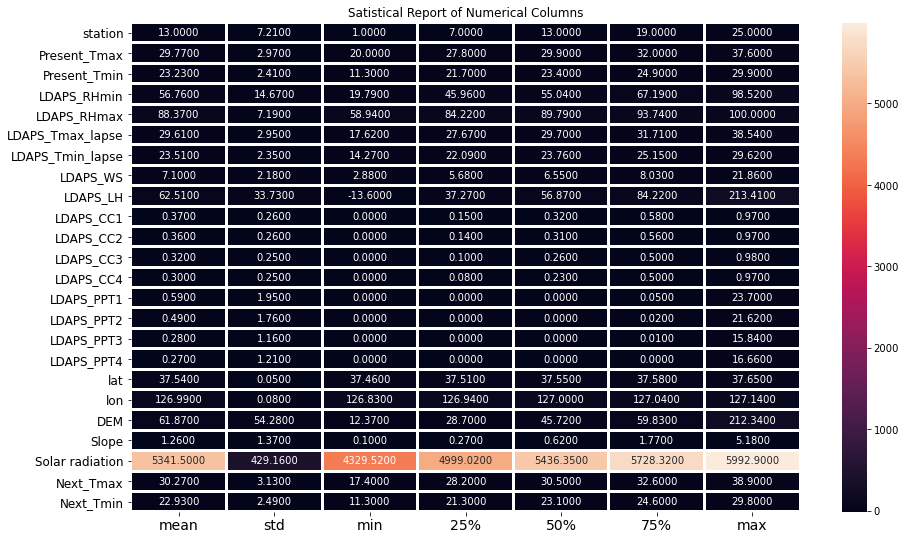

In [7]:
# visualizing the statistical description of numeric datatype columns

plt.figure(figsize = (15,9))
sns.heatmap(round(df.describe()[1:].transpose(),2), linewidth = 2, annot= True, fmt = ".4f")
plt.title("Satistical Report of Numerical Columns")
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 12)
plt.show()

So the column that stands out the most in terms of values that are present in the column name Solar radiation. We can see that this particular column has numeric data higher than all the remaining columns present in our entire dataset.

# Data preprocessing

In [8]:
df['Date']=pd.to_datetime(df['Date'])
df['Day']=df['Date'].apply(lambda x:x.day)
df['Month']=df['Date'].apply(lambda x:x.month)
df['Year']=df['Date'].apply(lambda x:x.year)
df.drop('Date', axis=1, inplace=True)
df.head()

,station,Present_Tmax,Present_Tmin,LDAPS_RHmin,LDAPS_RHmax,LDAPS_Tmax_lapse,LDAPS_Tmin_lapse,LDAPS_WS,LDAPS_LH,LDAPS_CC1,...,lat,lon,DEM,Slope,Solar radiation,Next_Tmax,Next_Tmin,Day,Month,Year
0,1.0,28.7,21.4,58.255688,91.116364,28.074101,23.006936,6.818887,69.451805,0.233947,...,37.6046,126.991,212.3350,2.7850,5992.895996,29.1,21.2,30.0,6.0,2013.0
1,2.0,31.9,21.6,52.263397,90.604721,29.850689,24.035009,5.691890,51.937448,0.225508,...,37.6046,127.032,44.7624,0.5141,5869.312500,30.5,22.5,30.0,6.0,2013.0
2,3.0,31.6,23.3,48.690479,83.973587,30.091292,24.565633,6.138224,20.573050,0.209344,...,37.5776,127.058,33.3068,0.2661,5863.555664,31.1,23.9,30.0,6.0,2013.0
3,4.0,32.0,23.4,58.239788,96.483688,29.704629,23.326177,5.650050,65.727144,0.216372,...,37.6450,127.022,45.7160,2.5348,5856.964844,31.7,24.3,30.0,6.0,2013.0
4,5.0,31.4,21.9,56.174095,90.155128,29.113934,23.486480,5.735004,107.965535,0.151407,...,37.5507,127.135,35.0380,0.5055,5859.552246,31.2,22.5,30.0,6.0,2013.0


Here we have removed the object datatype "Date" column and separated the "Date" column into three different columns namely day - month -  year with the help of pandas Datetime option.

In [10]:
geodata=[]
def reverse_geocoordinates(coordinates):
    result = rg.search(coordinates)
    return (result)

if __name__=="__main__":
    coordinates = list(zip(df['lat'], df['lon']))
    data = reverse_geocoordinates(coordinates)
    geodata.append(data)

geo_names = pd.DataFrame(geodata).transpose()
print(geo_names)

Loading formatted geocoded file...
                                                      0
0     {'lat': '37.566', 'lon': '126.9784', 'name': '...
1     {'lat': '37.566', 'lon': '126.9784', 'name': '...
2     {'lat': '37.566', 'lon': '126.9784', 'name': '...
3     {'lat': '37.566', 'lon': '126.9784', 'name': '...
4     {'lat': '37.5986', 'lon': '127.1394', 'name': ...
...                                                 ...
7747  {'lat': '37.47722', 'lon': '126.86639', 'name'...
7748  {'lat': '37.47722', 'lon': '126.86639', 'name'...
7749  {'lat': '37.566', 'lon': '126.9784', 'name': '...
7750  {'lat': '37.47722', 'lon': '126.86639', 'name'...
7751  {'lat': '37.5986', 'lon': '127.1394', 'name': ...

[7752 rows x 1 columns]


So here I have acquired the state and city names corresponding to it's latitude and longitude data however we will need to incorporate it properly inside our dataset and format it.

In [11]:
df['State']=geo_names[0].apply(lambda x:x.get('admin1'))
df['City']=geo_names[0].apply(lambda x:x.get('name'))
df.drop(['lat','lon'], axis=1, inplace=True)
df

,station,Present_Tmax,Present_Tmin,LDAPS_RHmin,LDAPS_RHmax,LDAPS_Tmax_lapse,LDAPS_Tmin_lapse,LDAPS_WS,LDAPS_LH,LDAPS_CC1,...,DEM,Slope,Solar radiation,Next_Tmax,Next_Tmin,Day,Month,Year,State,City
0,1.0,28.7,21.4,58.255688,91.116364,28.074101,23.006936,6.818887,69.451805,0.233947,...,212.3350,2.785000,5992.895996,29.1,21.2,30.0,6.0,2013.0,Seoul,Seoul
1,2.0,31.9,21.6,52.263397,90.604721,29.850689,24.035009,5.691890,51.937448,0.225508,...,44.7624,0.514100,5869.312500,30.5,22.5,30.0,6.0,2013.0,Seoul,Seoul
2,3.0,31.6,23.3,48.690479,83.973587,30.091292,24.565633,6.138224,20.573050,0.209344,...,33.3068,0.266100,5863.555664,31.1,23.9,30.0,6.0,2013.0,Seoul,Seoul
3,4.0,32.0,23.4,58.239788,96.483688,29.704629,23.326177,5.650050,65.727144,0.216372,...,45.7160,2.534800,5856.964844,31.7,24.3,30.0,6.0,2013.0,Seoul,Seoul
4,5.0,31.4,21.9,56.174095,90.155128,29.113934,23.486480,5.735004,107.965535,0.151407,...,35.0380,0.505500,5859.552246,31.2,22.5,30.0,6.0,2013.0,Gyeonggi-do,Guri-si
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7747,23.0,23.3,17.1,26.741310,78.869858,26.352081,18.775678,6.148918,72.058294,0.030034,...,15.5876,0.155400,4443.313965,28.3,18.1,30.0,8.0,2017.0,Gyeonggi-do,Kwangmyong
7748,24.0,23.3,17.7,24.040634,77.294975,27.010193,18.733519,6.542819,47.241457,0.035874,...,17.2956,0.222300,4438.373535,28.6,18.8,30.0,8.0,2017.0,Gyeonggi-do,Kwangmyong
7749,25.0,23.2,17.4,22.933014,77.243744,27.939516,18.522965,7.289264,9.090034,0.048954,...,19.5844,0.271300,4451.345215,27.8,17.4,30.0,8.0,2017.0,Seoul,Seoul
7750,NaN,20.0,11.3,19.794666,58.936283,17.624954,14.272646,2.882580,-13.603212,0.000000,...,12.3700,0.098475,4329.520508,17.4,11.3,NaN,NaN,NaN,Gyeonggi-do,Kwangmyong


I was successfully able to create 2 new columns for state and city in our dataframe corresponding to their lattude and longitude locations. Since the information was achieved I have dropped the original columns "lat" and "lon" to avoid duplicate data columns.

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7752 entries, 0 to 7751
Data columns (total 27 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   station           7750 non-null   float64
 1   Present_Tmax      7682 non-null   float64
 2   Present_Tmin      7682 non-null   float64
 3   LDAPS_RHmin       7677 non-null   float64
 4   LDAPS_RHmax       7677 non-null   float64
 5   LDAPS_Tmax_lapse  7677 non-null   float64
 6   LDAPS_Tmin_lapse  7677 non-null   float64
 7   LDAPS_WS          7677 non-null   float64
 8   LDAPS_LH          7677 non-null   float64
 9   LDAPS_CC1         7677 non-null   float64
 10  LDAPS_CC2         7677 non-null   float64
 11  LDAPS_CC3         7677 non-null   float64
 12  LDAPS_CC4         7677 non-null   float64
 13  LDAPS_PPT1        7677 non-null   float64
 14  LDAPS_PPT2        7677 non-null   float64
 15  LDAPS_PPT3        7677 non-null   float64
 16  LDAPS_PPT4        7677 non-null   float64


In the above cell we can see that our 3 separated date columns namely day, month and year now have float datatype values. And the 2 new additional columns "State" and "City" has object datatype values that will need to be encoded later on before we start building our machine learning model.

In [13]:
df.nunique().to_frame("Unique Values")

,Unique Values
station,25
Present_Tmax,167
Present_Tmin,155
LDAPS_RHmin,7672
LDAPS_RHmax,7664
LDAPS_Tmax_lapse,7675
LDAPS_Tmin_lapse,7675
LDAPS_WS,7675
LDAPS_LH,7675
LDAPS_CC1,7569


In [14]:
df.isna().sum()

station              2
Present_Tmax        70
Present_Tmin        70
LDAPS_RHmin         75
LDAPS_RHmax         75
LDAPS_Tmax_lapse    75
LDAPS_Tmin_lapse    75
LDAPS_WS            75
LDAPS_LH            75
LDAPS_CC1           75
LDAPS_CC2           75
LDAPS_CC3           75
LDAPS_CC4           75
LDAPS_PPT1          75
LDAPS_PPT2          75
LDAPS_PPT3          75
LDAPS_PPT4          75
DEM                  0
Slope                0
Solar radiation      0
Next_Tmax           27
Next_Tmin           27
Day                  2
Month                2
Year                 2
State                0
City                 0
dtype: int64

<AxesSubplot:>

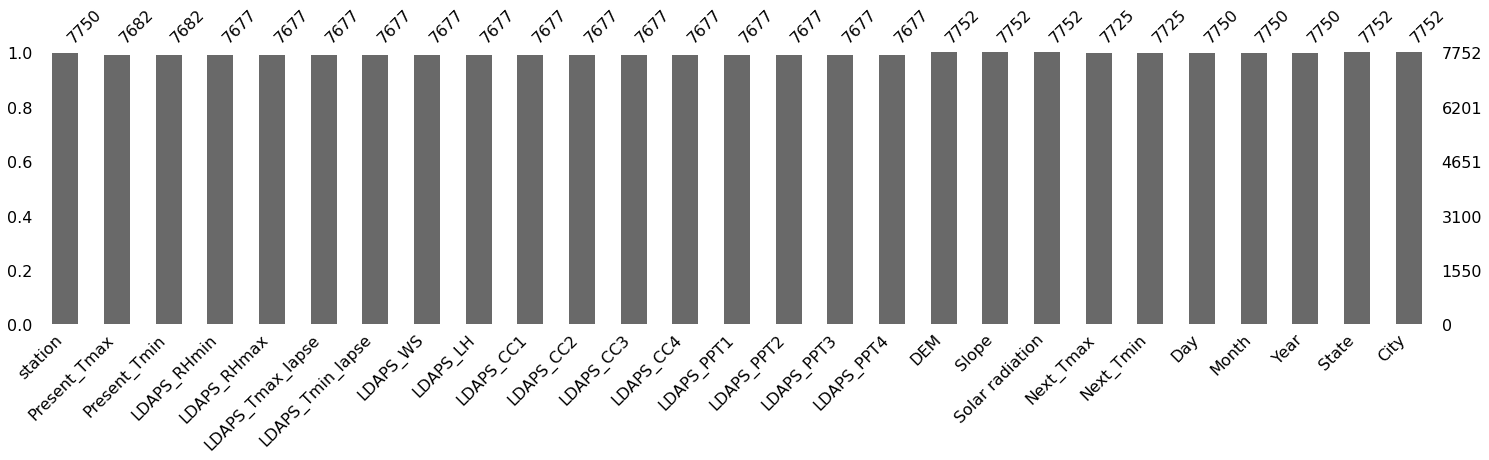

In [15]:
missingno.bar(df, figsize = (25,5))

In [16]:
print("Missing values in percentage:\n")
for col in df:
    percentage = np.round((df[col].isnull().sum()/df.shape[0])*100, 3)
    print(col, ":".format(), percentage, '%')

Missing values in percentage:

station : 0.026 %
Present_Tmax : 0.903 %
Present_Tmin : 0.903 %
LDAPS_RHmin : 0.967 %
LDAPS_RHmax : 0.967 %
LDAPS_Tmax_lapse : 0.967 %
LDAPS_Tmin_lapse : 0.967 %
LDAPS_WS : 0.967 %
LDAPS_LH : 0.967 %
LDAPS_CC1 : 0.967 %
LDAPS_CC2 : 0.967 %
LDAPS_CC3 : 0.967 %
LDAPS_CC4 : 0.967 %
LDAPS_PPT1 : 0.967 %
LDAPS_PPT2 : 0.967 %
LDAPS_PPT3 : 0.967 %
LDAPS_PPT4 : 0.967 %
DEM : 0.0 %
Slope : 0.0 %
Solar radiation : 0.0 %
Next_Tmax : 0.348 %
Next_Tmin : 0.348 %
Day : 0.026 %
Month : 0.026 %
Year : 0.026 %
State : 0.0 %
City : 0.0 %


In [17]:
print("We had {} Rows and {} Columns before dropping null values.".format(df.shape[0], df.shape[1]))
df.dropna(inplace=True)
print("We have {} Rows and {} Columns after dropping null values.".format(df.shape[0], df.shape[1]))

We had 7752 Rows and 27 Columns before dropping null values.
We have 7588 Rows and 27 Columns after dropping null values.


In [18]:
df.isnull().sum()

station             0
Present_Tmax        0
Present_Tmin        0
LDAPS_RHmin         0
LDAPS_RHmax         0
LDAPS_Tmax_lapse    0
LDAPS_Tmin_lapse    0
LDAPS_WS            0
LDAPS_LH            0
LDAPS_CC1           0
LDAPS_CC2           0
LDAPS_CC3           0
LDAPS_CC4           0
LDAPS_PPT1          0
LDAPS_PPT2          0
LDAPS_PPT3          0
LDAPS_PPT4          0
DEM                 0
Slope               0
Solar radiation     0
Next_Tmax           0
Next_Tmin           0
Day                 0
Month               0
Year                0
State               0
City                0
dtype: int64

Now we have a dataframe that does not have any missing data in it.

# Visualization

In [19]:
col = ['station', 'Present_Tmax', 'Present_Tmin', 'LDAPS_RHmin', 'LDAPS_RHmax',
       'LDAPS_Tmax_lapse', 'LDAPS_Tmin_lapse', 'LDAPS_WS', 'LDAPS_LH',
       'LDAPS_CC1', 'LDAPS_CC2', 'LDAPS_CC3', 'LDAPS_CC4', 'LDAPS_PPT1',
       'LDAPS_PPT2', 'LDAPS_PPT3', 'LDAPS_PPT4', 'DEM', 'Slope',
       'Solar radiation', 'Next_Tmax', 'Next_Tmin', 'Day', 'Month', 'Year',
       'State', 'City']
print(col)

['station', 'Present_Tmax', 'Present_Tmin', 'LDAPS_RHmin', 'LDAPS_RHmax', 'LDAPS_Tmax_lapse', 'LDAPS_Tmin_lapse', 'LDAPS_WS', 'LDAPS_LH', 'LDAPS_CC1', 'LDAPS_CC2', 'LDAPS_CC3', 'LDAPS_CC4', 'LDAPS_PPT1', 'LDAPS_PPT2', 'LDAPS_PPT3', 'LDAPS_PPT4', 'DEM', 'Slope', 'Solar radiation', 'Next_Tmax', 'Next_Tmin', 'Day', 'Month', 'Year', 'State', 'City']


Storing all the column names present in our dataframe in a separate list that might come in handy later on

State


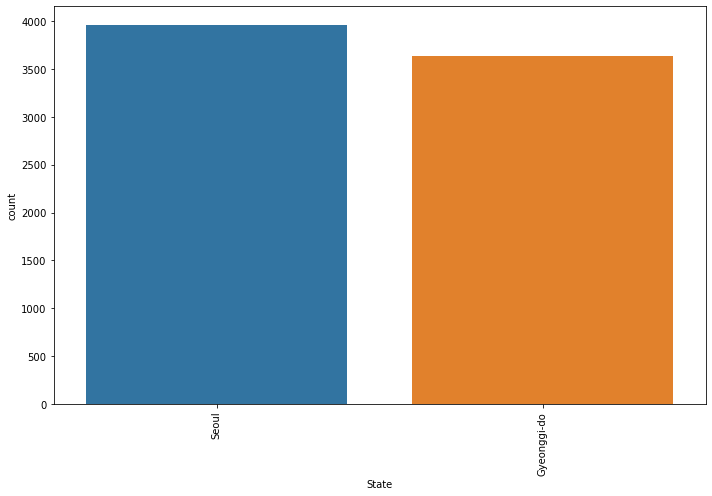

Year


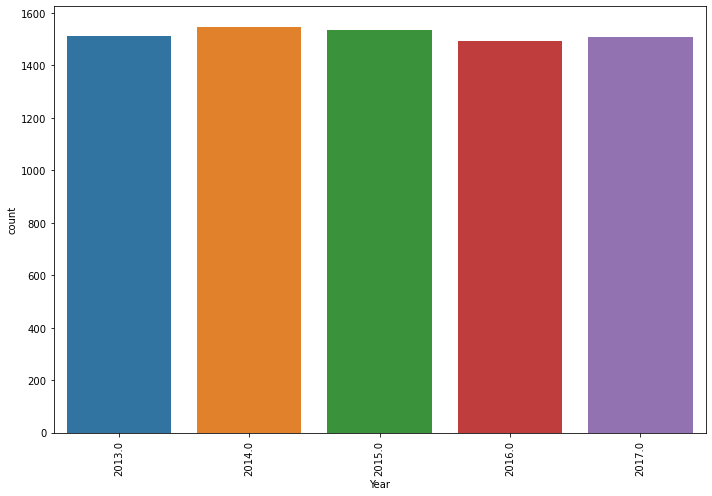

City


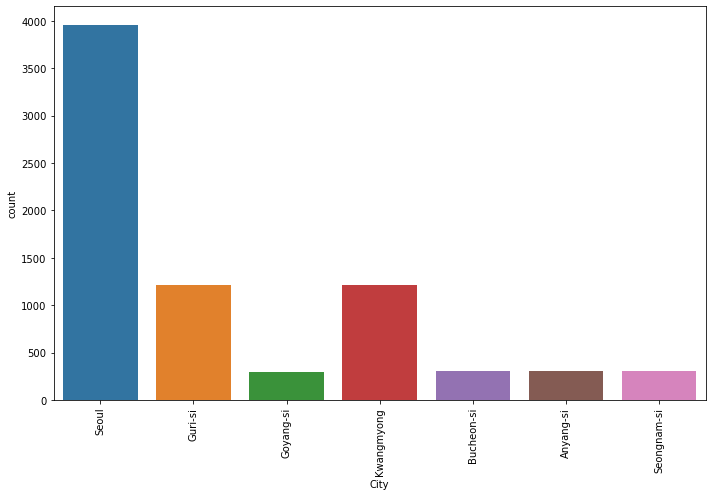

Month


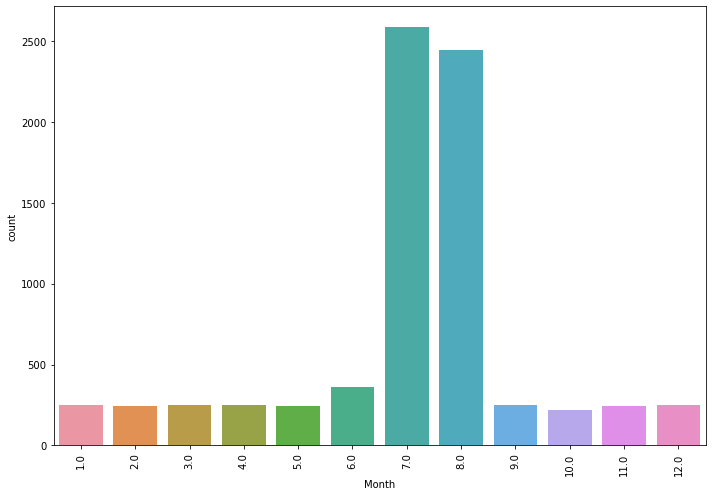

Day


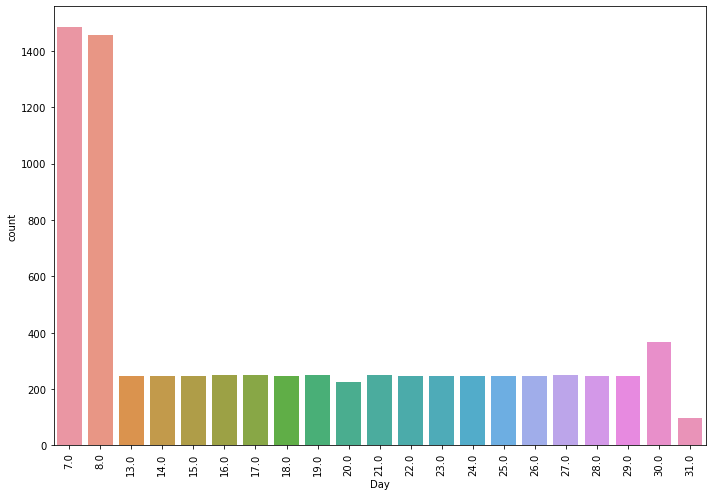

station


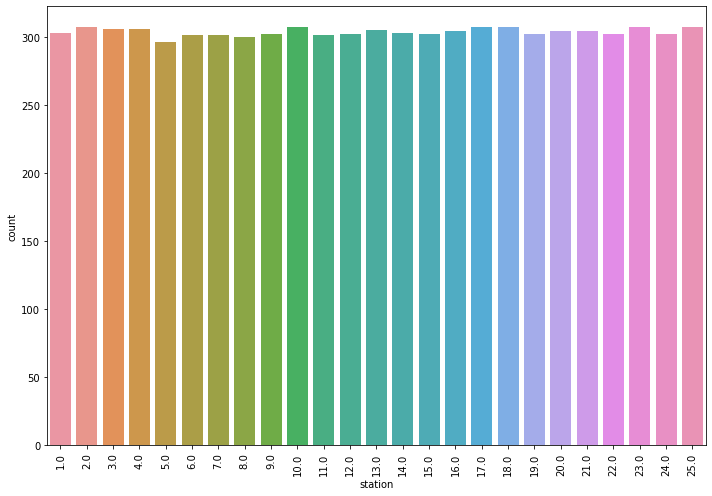

DEM


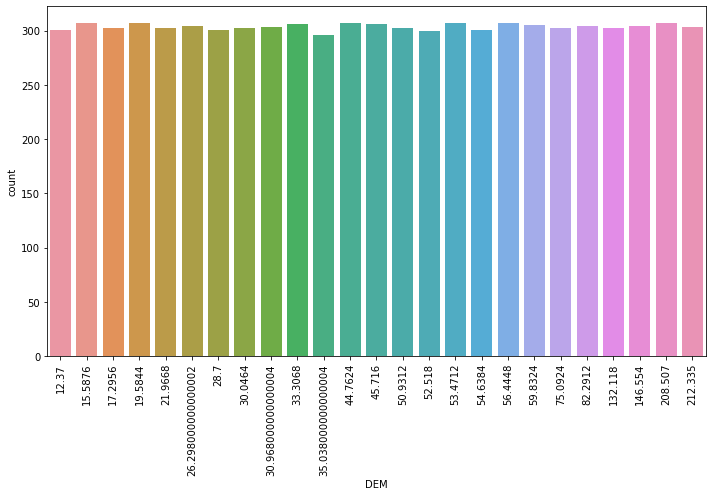

Slope


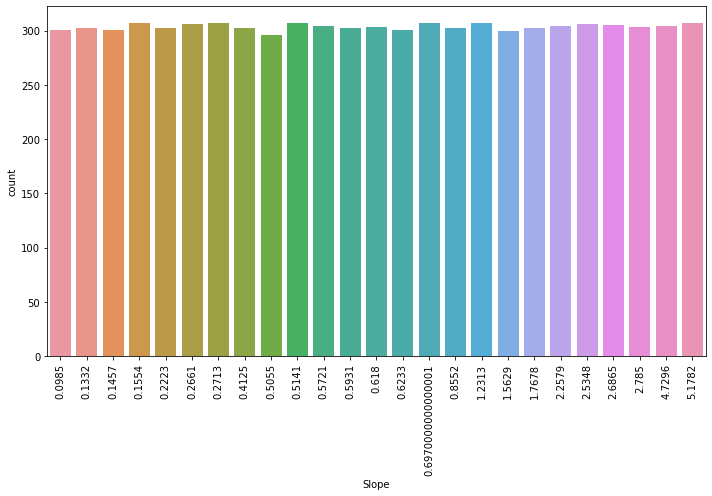

In [20]:
def countplot(x):
    plt.figure(figsize=(10,7))
    sns.countplot(x)
    plt.xticks(rotation=90)
    plt.tight_layout()
    return plt.show()

col1 = ['State', 'Year', 'City', 'Month', 'Day', 'station', 'DEM', 'Slope']

for i in col1:
    print(i)
    countplot(df[i])

Columns with less than 30 unique values:
- State(2) shows values for Seoul is slightly higher than Gyeonggi-do province
- Year(5) shows that almost all year data points have equal coverage
- City(7) shows that Seoul has the highest number amongst all the other categories
- Month(12) shows a very high peak in data for months July and August
- Day(21) shows a very high peak in data for days 7 and 8 of a month
- station(25) also shows almost equal data coverage for all it's unique values
- DEM(25) has almost equal data coverage for all it's unique values
- Slope(27) again shows almost equal data coverage for all it's unique values

In [21]:
col2 = [x for x in col if x not in col1]
print(col2)

['Present_Tmax', 'Present_Tmin', 'LDAPS_RHmin', 'LDAPS_RHmax', 'LDAPS_Tmax_lapse', 'LDAPS_Tmin_lapse', 'LDAPS_WS', 'LDAPS_LH', 'LDAPS_CC1', 'LDAPS_CC2', 'LDAPS_CC3', 'LDAPS_CC4', 'LDAPS_PPT1', 'LDAPS_PPT2', 'LDAPS_PPT3', 'LDAPS_PPT4', 'Solar radiation', 'Next_Tmax', 'Next_Tmin']


Here I have noted down all the column names that have unique value more than 30.

Present_Tmax


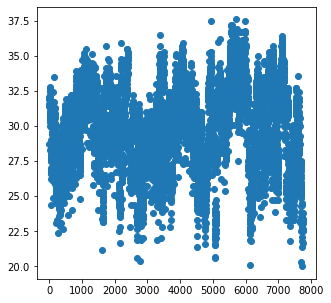

Present_Tmin


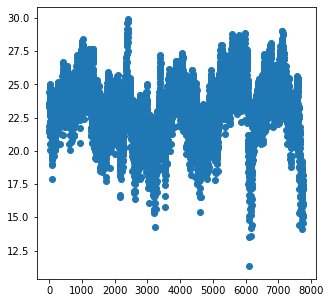

LDAPS_RHmin


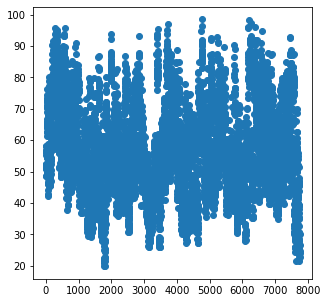

LDAPS_RHmax


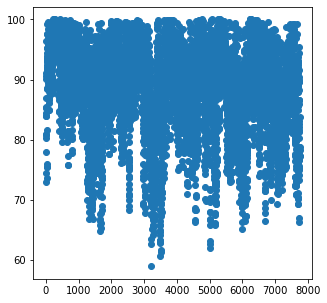

LDAPS_Tmax_lapse


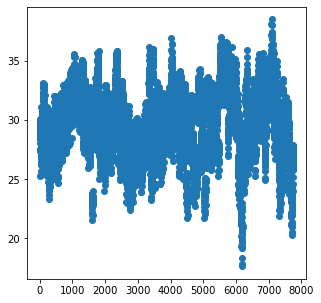

LDAPS_Tmin_lapse


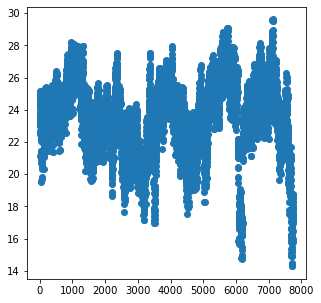

LDAPS_WS


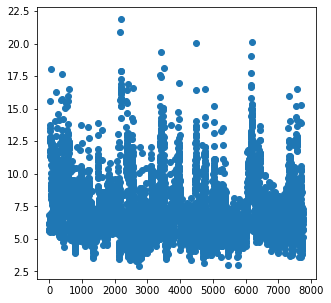

LDAPS_LH


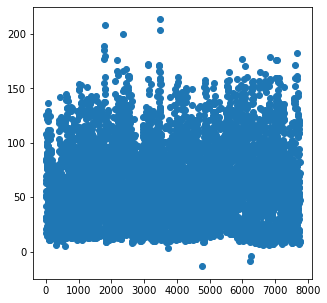

LDAPS_CC1


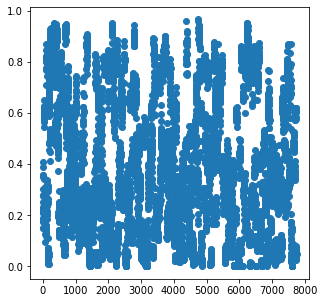

LDAPS_CC2


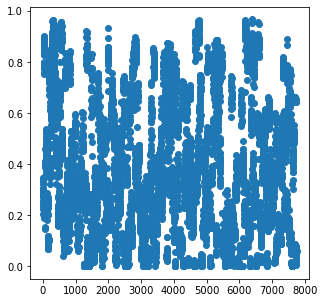

LDAPS_CC3


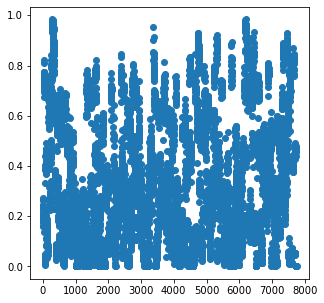

LDAPS_CC4


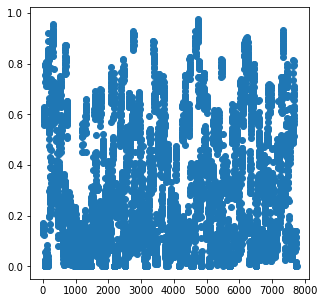

LDAPS_PPT1


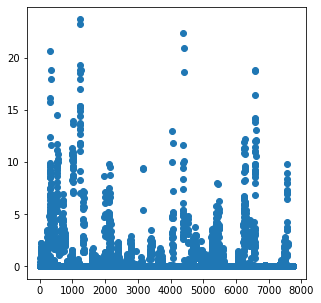

LDAPS_PPT2


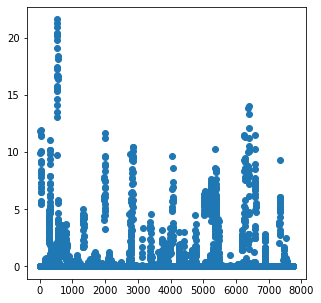

LDAPS_PPT3


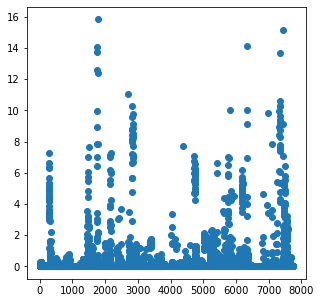

LDAPS_PPT4


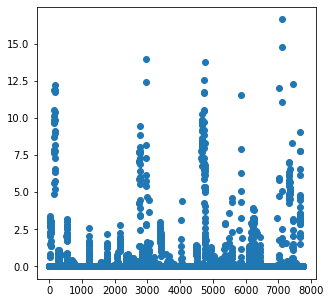

Solar radiation


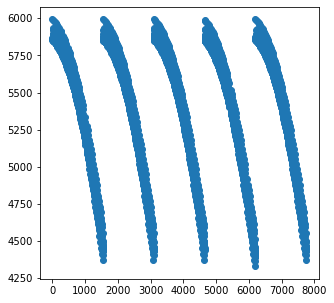

Next_Tmax


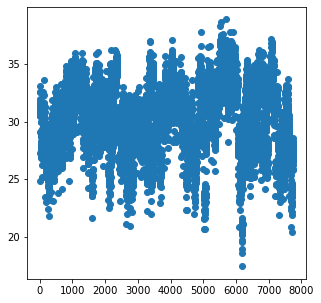

Next_Tmin


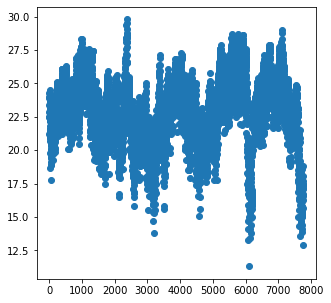

In [22]:
for j in df[col2]:
    plt.figure(figsize=(5,5))
    print(j)
    plt.scatter(df.index, df[j])
    plt.show()

I have generated a scatter plot for each and every numeric value column that has more than 30 unique values showing the dispersion of datapoints where Y axis has the column details and X axis has the index of all the rows corresponding to where those information are present.

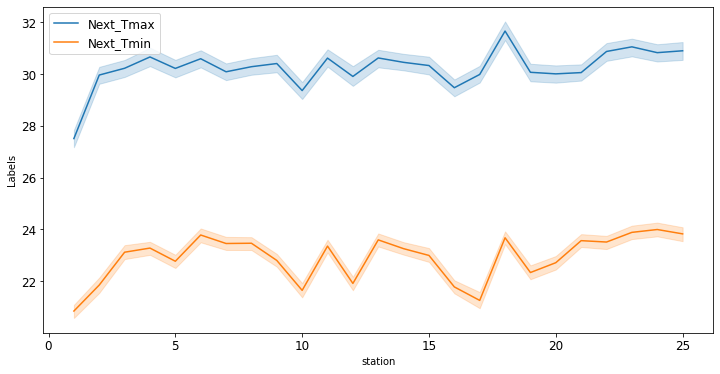

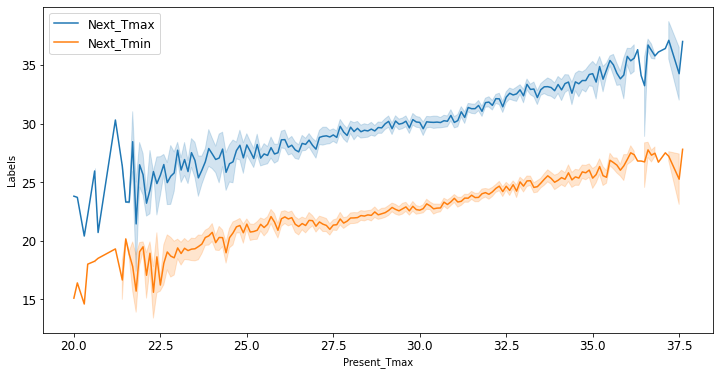

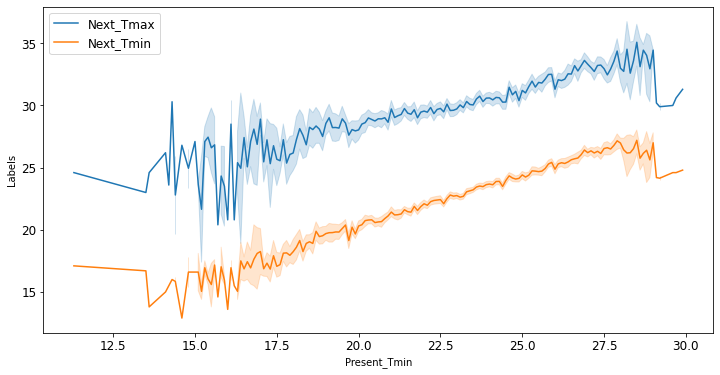

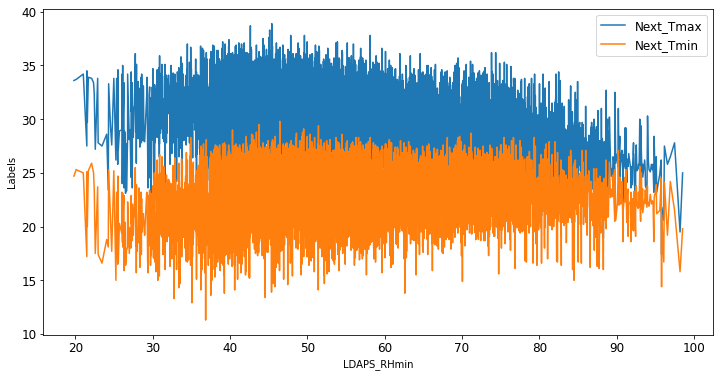

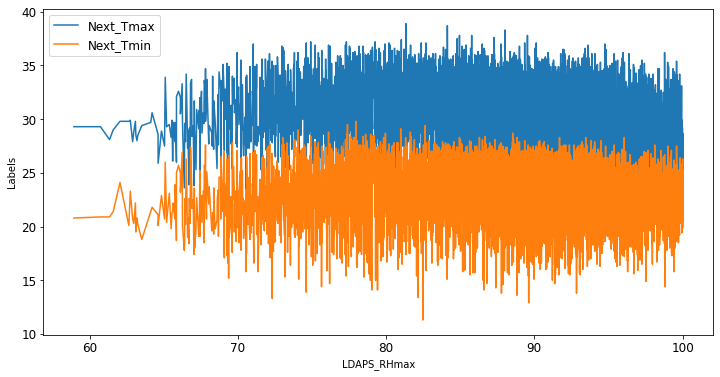

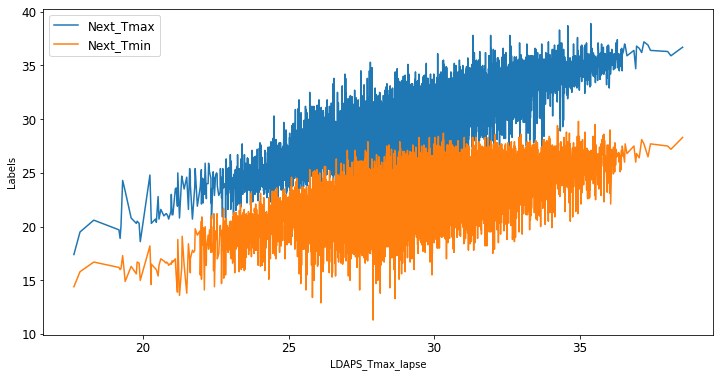

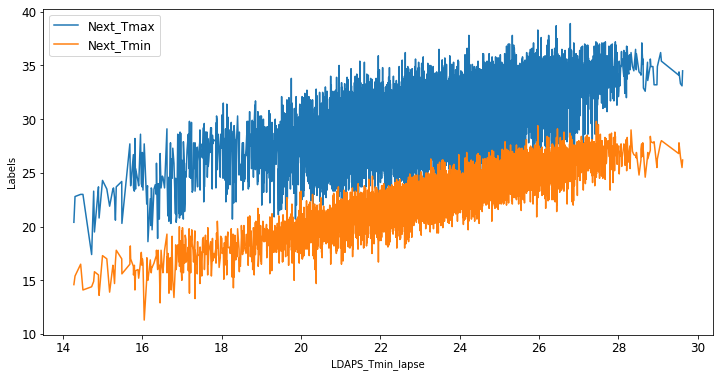

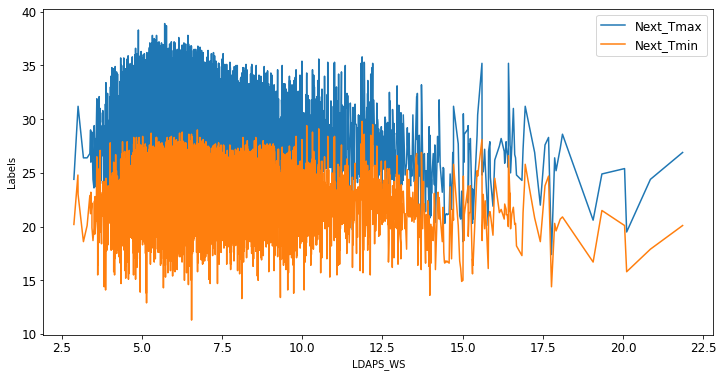

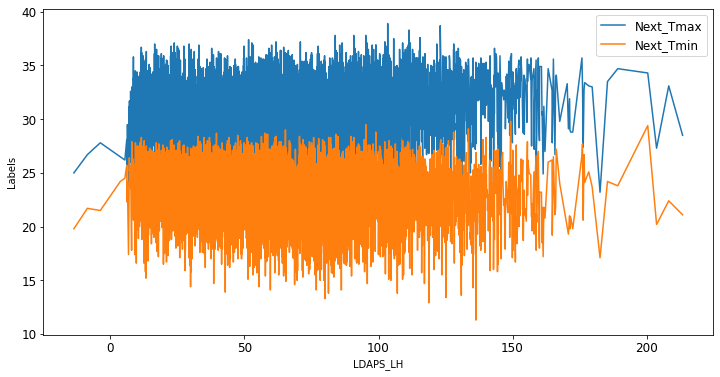

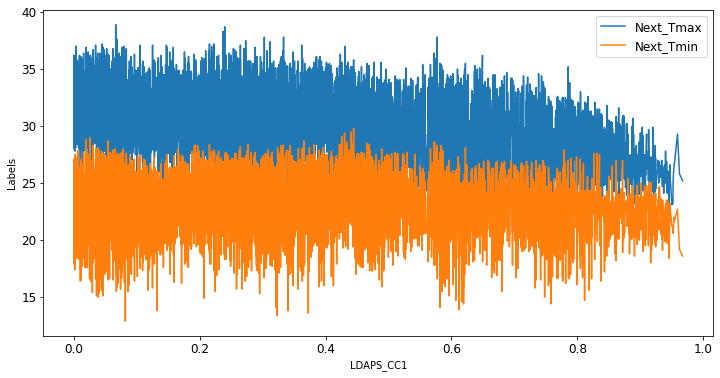

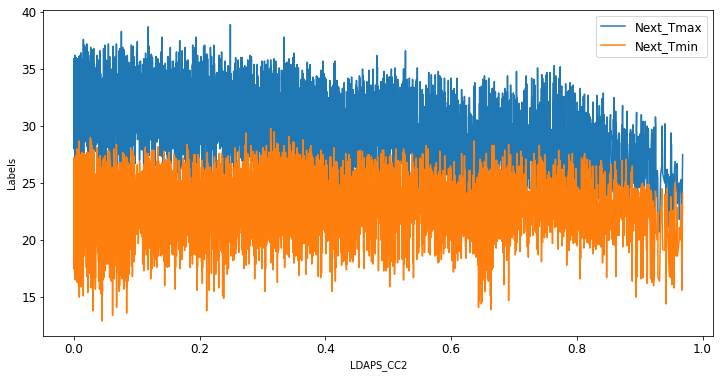

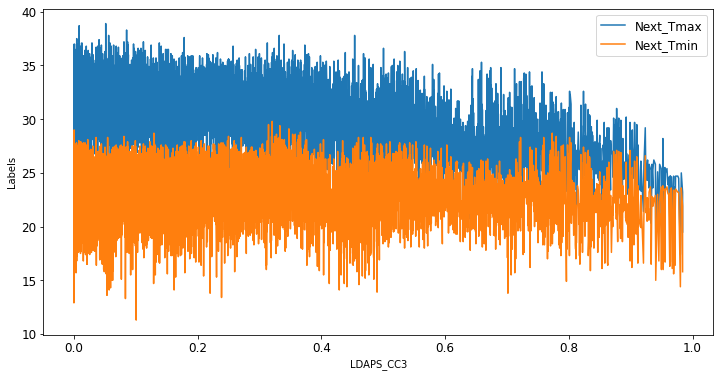

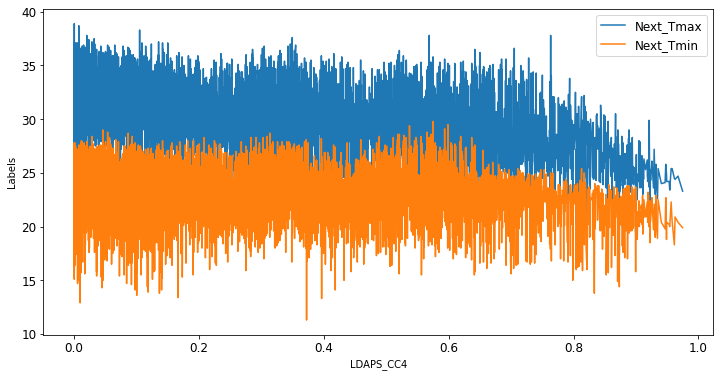

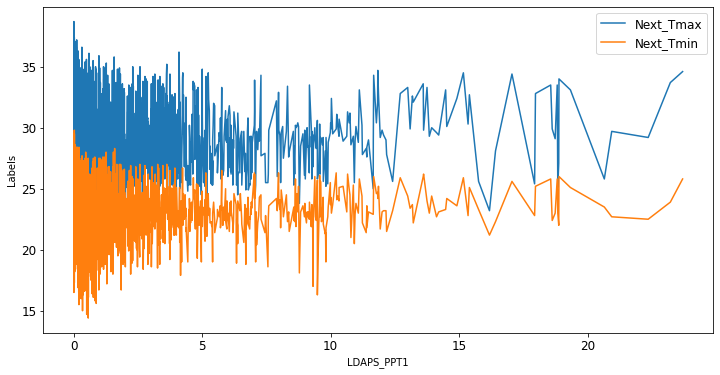

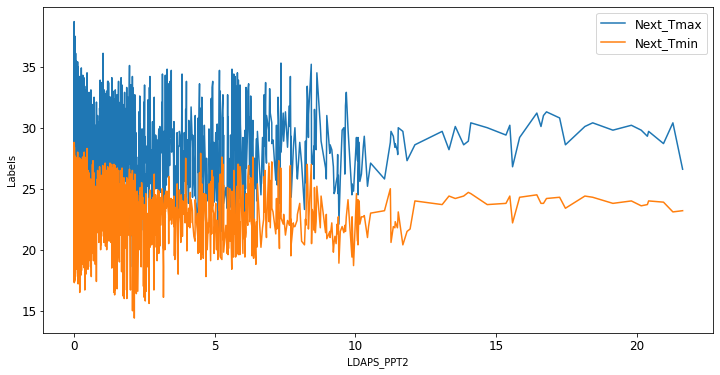

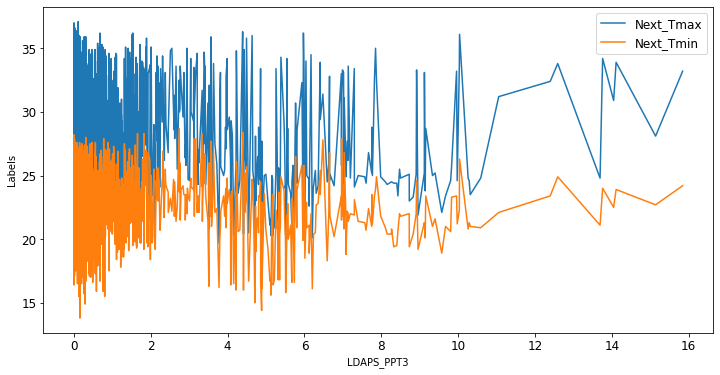

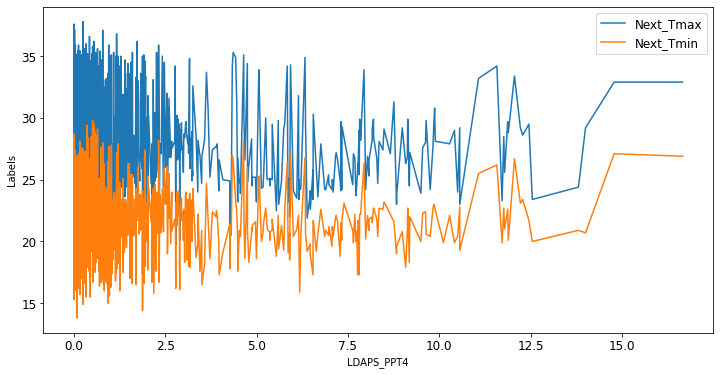

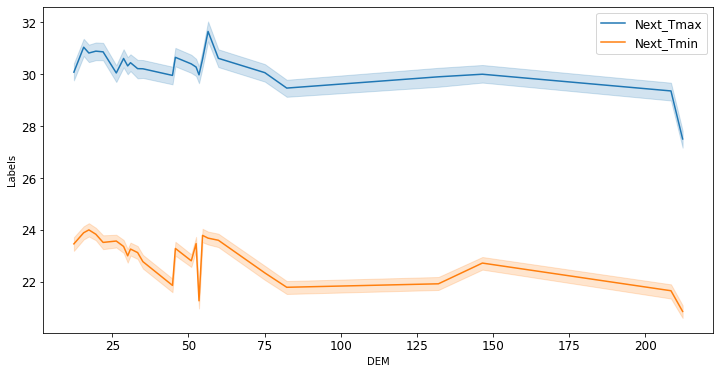

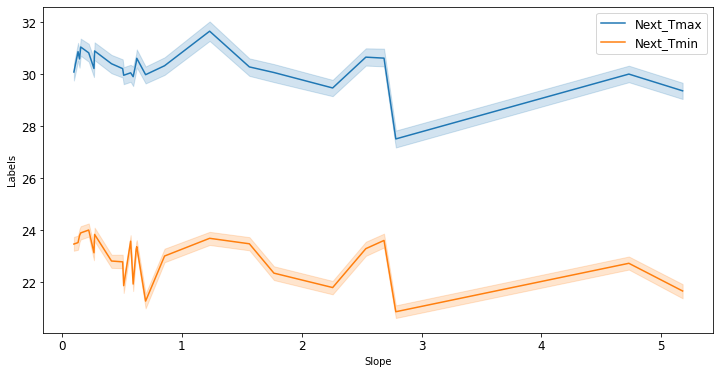

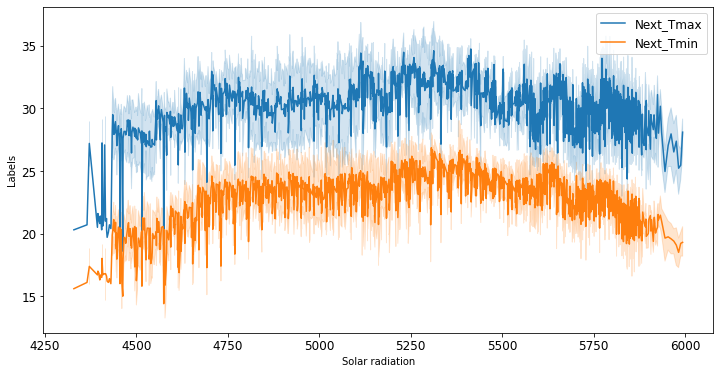

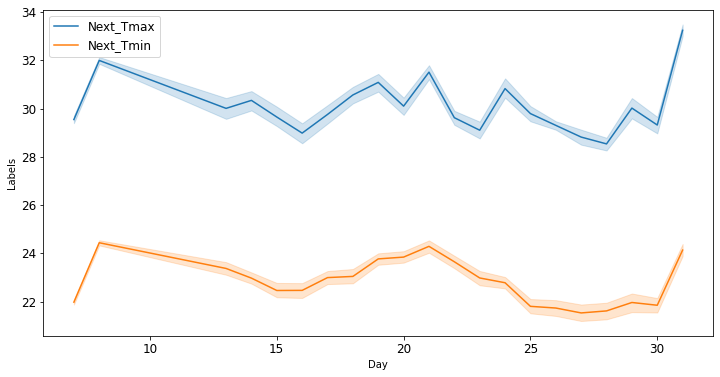

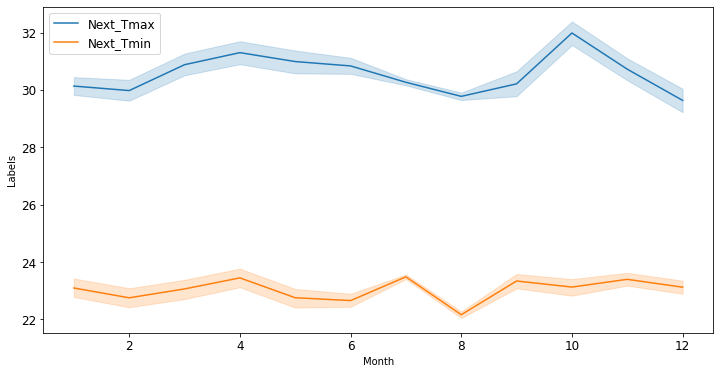

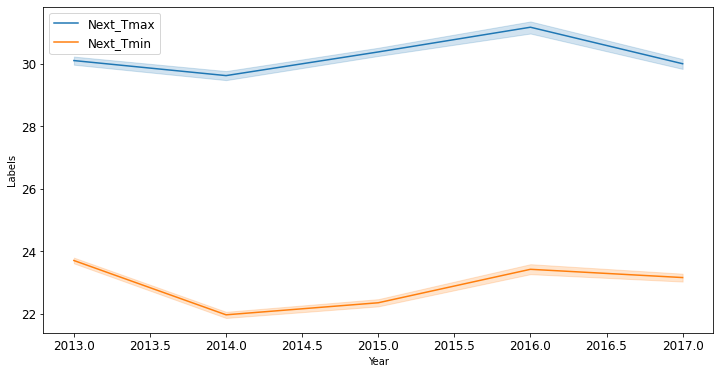

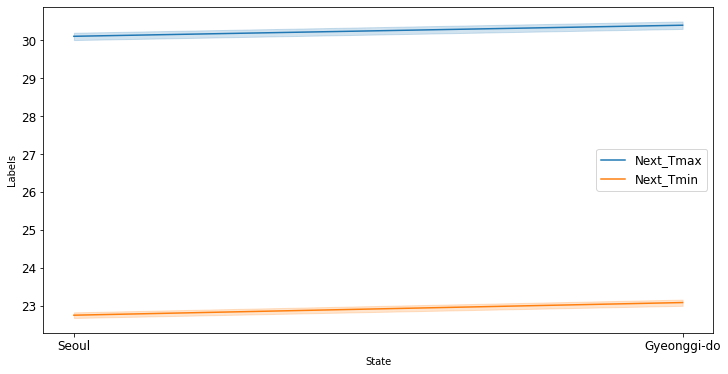

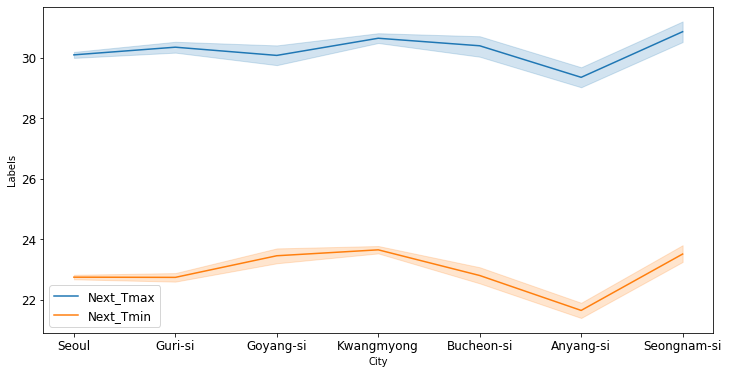

In [23]:
feature_columns = ['station', 'Present_Tmax', 'Present_Tmin', 'LDAPS_RHmin', 'LDAPS_RHmax', 'LDAPS_Tmax_lapse', 
                   'LDAPS_Tmin_lapse', 'LDAPS_WS', 'LDAPS_LH', 'LDAPS_CC1', 'LDAPS_CC2', 'LDAPS_CC3', 'LDAPS_CC4', 
                   'LDAPS_PPT1', 'LDAPS_PPT2', 'LDAPS_PPT3', 'LDAPS_PPT4', 'DEM', 'Slope', 'Solar radiation', 'Day', 
                   'Month', 'Year', 'State', 'City']

label_columns = ['Next_Tmax', 'Next_Tmin']

for z in df[feature_columns]:
    plt.figure(figsize=(12,6))
    sns.lineplot(x=df[z], y=label_columns[0], data=df)
    sns.lineplot(x=df[z], y=label_columns[1], data=df)
    plt.ylabel("Labels")
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.legend(['Next_Tmax', 'Next_Tmin'], fontsize=12)
    plt.show()

With the help of above line plots we are able to see the data distribution between our feature columns with respect to our label values.

# Encoding the categorical object datatype columns

In [24]:
# Ordinal Encoder

oe = OrdinalEncoder()
def ordinal_encode(df, column):
    df[column] = oe.fit_transform(df[column])
    return df

df=ordinal_encode(df, ['State', 'City'])
df.head()

,station,Present_Tmax,Present_Tmin,LDAPS_RHmin,LDAPS_RHmax,LDAPS_Tmax_lapse,LDAPS_Tmin_lapse,LDAPS_WS,LDAPS_LH,LDAPS_CC1,...,DEM,Slope,Solar radiation,Next_Tmax,Next_Tmin,Day,Month,Year,State,City
0,1.0,28.7,21.4,58.255688,91.116364,28.074101,23.006936,6.818887,69.451805,0.233947,...,212.3350,2.7850,5992.895996,29.1,21.2,30.0,6.0,2013.0,1.0,6.0
1,2.0,31.9,21.6,52.263397,90.604721,29.850689,24.035009,5.691890,51.937448,0.225508,...,44.7624,0.5141,5869.312500,30.5,22.5,30.0,6.0,2013.0,1.0,6.0
2,3.0,31.6,23.3,48.690479,83.973587,30.091292,24.565633,6.138224,20.573050,0.209344,...,33.3068,0.2661,5863.555664,31.1,23.9,30.0,6.0,2013.0,1.0,6.0
3,4.0,32.0,23.4,58.239788,96.483688,29.704629,23.326177,5.650050,65.727144,0.216372,...,45.7160,2.5348,5856.964844,31.7,24.3,30.0,6.0,2013.0,1.0,6.0
4,5.0,31.4,21.9,56.174095,90.155128,29.113934,23.486480,5.735004,107.965535,0.151407,...,35.0380,0.5055,5859.552246,31.2,22.5,30.0,6.0,2013.0,0.0,3.0


I have used `OrdinalEncoder` inside a function to loop through both the categorical data columns and convert those feature values from object datatype to numerical datatype values.

In [25]:
print("Shape of our data frame post encoding shows {} Rows and {} columns\n".format(df.shape[0], df.shape[1]))
df.info()

Shape of our data frame post encoding shows 7588 Rows and 27 columns

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7588 entries, 0 to 7749
Data columns (total 27 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   station           7588 non-null   float64
 1   Present_Tmax      7588 non-null   float64
 2   Present_Tmin      7588 non-null   float64
 3   LDAPS_RHmin       7588 non-null   float64
 4   LDAPS_RHmax       7588 non-null   float64
 5   LDAPS_Tmax_lapse  7588 non-null   float64
 6   LDAPS_Tmin_lapse  7588 non-null   float64
 7   LDAPS_WS          7588 non-null   float64
 8   LDAPS_LH          7588 non-null   float64
 9   LDAPS_CC1         7588 non-null   float64
 10  LDAPS_CC2         7588 non-null   float64
 11  LDAPS_CC3         7588 non-null   float64
 12  LDAPS_CC4         7588 non-null   float64
 13  LDAPS_PPT1        7588 non-null   float64
 14  LDAPS_PPT2        7588 non-null   float64
 15  LDAPS_PPT3        7

We have confirmed the rows and columns information post encoding and ensured that there are no object datatype or missing values in our dataset.

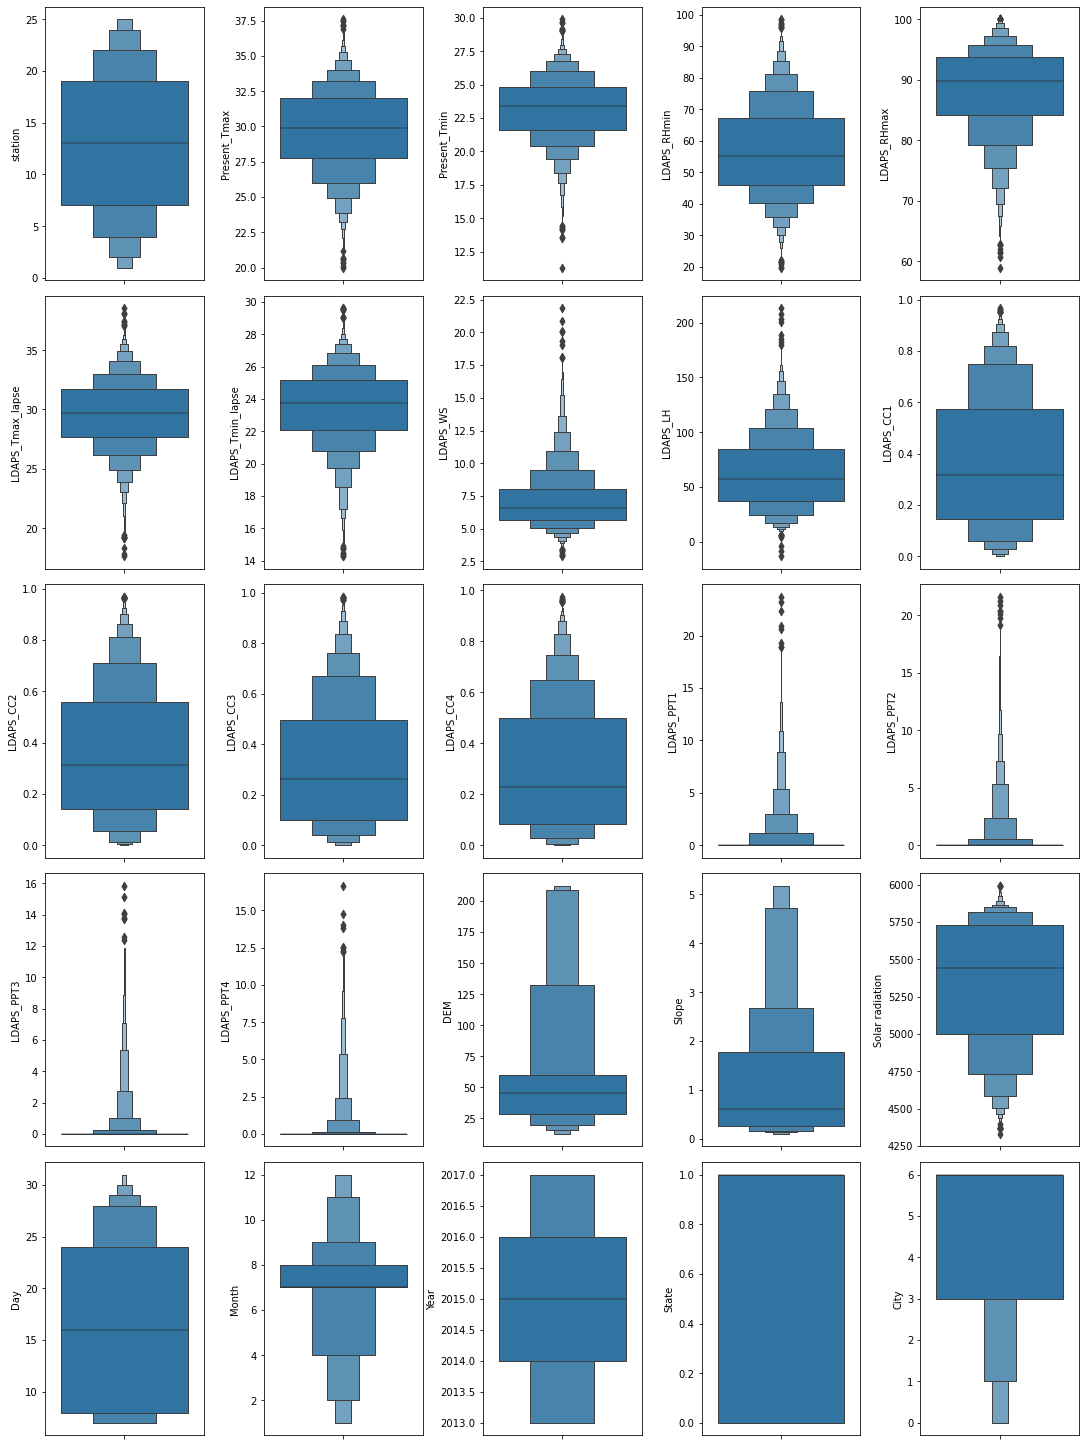

In [26]:
fig, ax = plt.subplots(ncols=5, nrows=5, figsize=(15,20))
index = 0
ax = ax.flatten()
for col, value in df[feature_columns].items():
    sns.boxenplot(y=col, data=df, ax=ax[index])
    index += 1
plt.tight_layout(pad=0.4, w_pad=0.4, h_pad=1.0)
plt.show()

With the help of boxen plot we can see the outlier details present in our numerical data columns which will need to be treated.

In [27]:
df.skew()

station            -0.004178
Present_Tmax       -0.257069
Present_Tmin       -0.353822
LDAPS_RHmin         0.301396
LDAPS_RHmax        -0.845264
LDAPS_Tmax_lapse   -0.222349
LDAPS_Tmin_lapse   -0.574035
LDAPS_WS            1.553926
LDAPS_LH            0.662971
LDAPS_CC1           0.456716
LDAPS_CC2           0.473929
LDAPS_CC3           0.639649
LDAPS_CC4           0.663815
LDAPS_PPT1          5.305906
LDAPS_PPT2          5.710360
LDAPS_PPT3          6.356670
LDAPS_PPT4          6.681256
DEM                 1.721617
Slope               1.559050
Solar radiation    -0.524325
Next_Tmax          -0.334842
Next_Tmin          -0.393662
Day                 0.245563
Month              -0.703092
Year                0.013575
State              -0.084964
City               -0.973089
dtype: float64

With the `skew` method we see that there are columns present in our dataset that are above the acceptable range of +/-0.5 value.

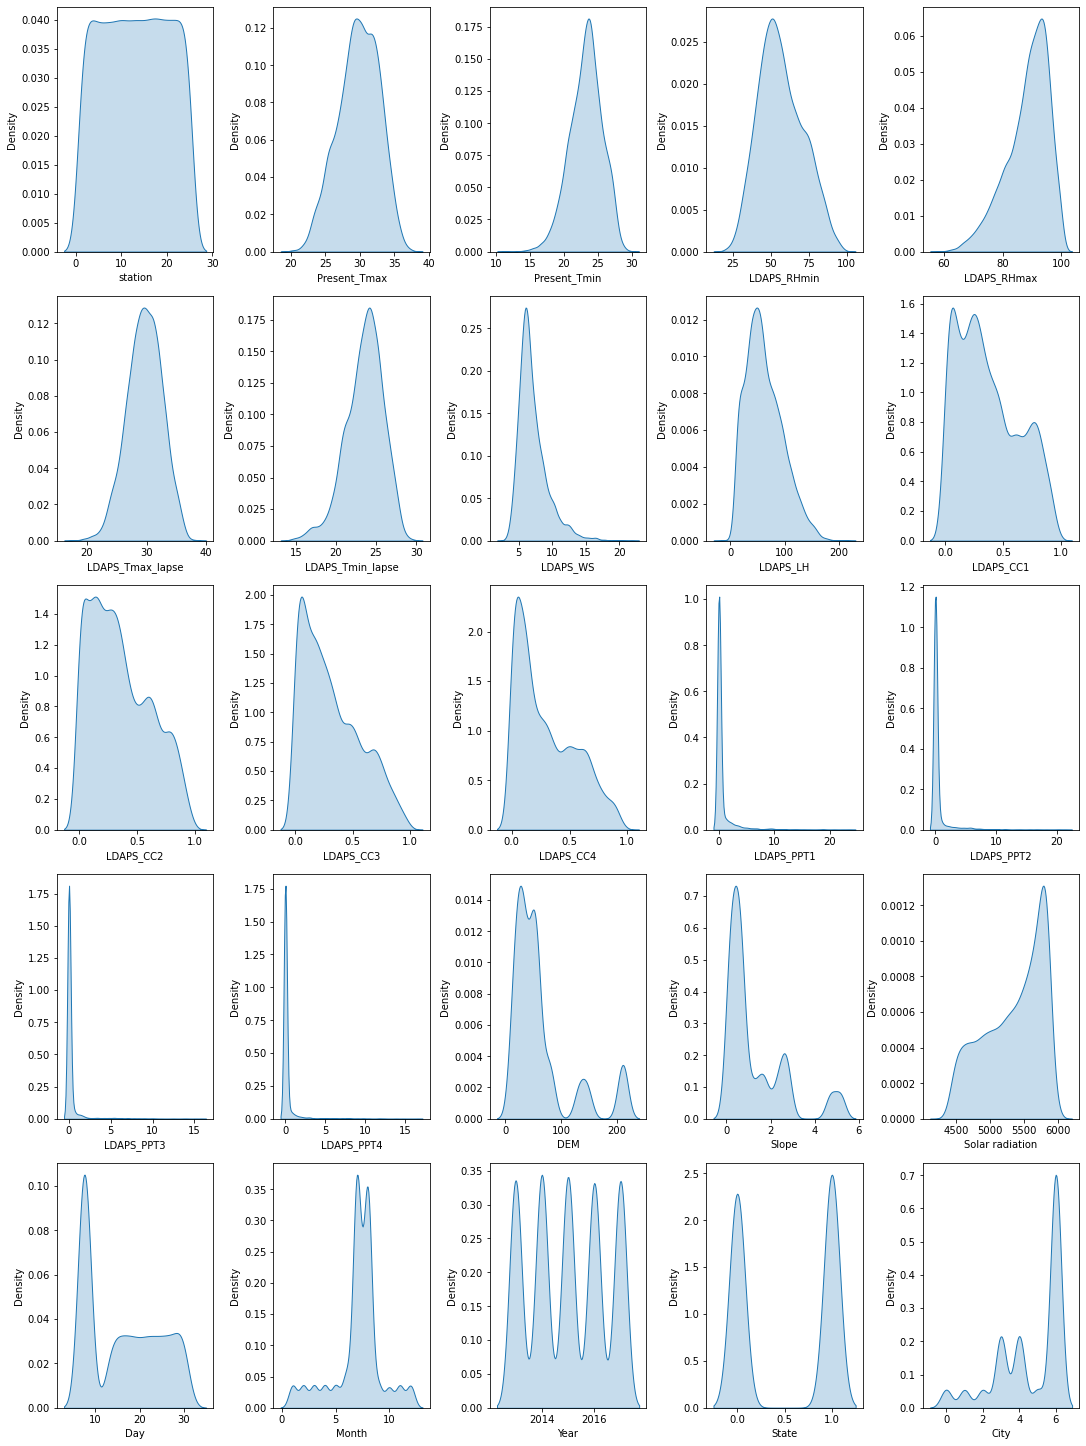

In [28]:
fig, ax = plt.subplots(ncols=5, nrows=5, figsize=(15,20))
index = 0
ax = ax.flatten()
for col, value in df[feature_columns].items():
    sns.distplot(value, ax=ax[index], hist=False, kde_kws={"shade": True})
    index += 1
plt.tight_layout(pad=0.4, w_pad=0.4, h_pad=1.0)
plt.show()

With the help of distribution plot we can see the skewness details present in our numerical data columns which will need to be treated.

# Using Z Score to remove outliers

In [29]:
z = np.abs(zscore(df))
threshold = 3
df1 = df[(z<3).all(axis = 1)]

print ("Shape of the dataframe before removing outliers: ", df.shape)
print ("Shape of the dataframe after removing outliers: ", df1.shape)
print ("Percentage of data loss post outlier removal: ", (df.shape[0]-df1.shape[0])/df.shape[0]*100)

df=df1.copy() # reassigning the changed dataframe name to our original dataframe name

Shape of the dataframe before removing outliers:  (7588, 27)
Shape of the dataframe after removing outliers:  (6739, 27)
Percentage of data loss post outlier removal:  11.188719030047443


I have used the Z score method to remove the outliers and the percent of data lost is 11.188719030047443 which is slightly higher than the threshold of 10 percent that we could have afforded to lose. But since it is not too high we will continue with the remaining data.

# Using Log Transform to fix skewness

In [30]:
for col in feature_columns:
    if df.skew().loc[col]>0.55:
        df[col]=np.log1p(df[col])

I have applied `Log Transformation` on our numerical datatype columns to ensure that we do not have skewness in our features dataset.

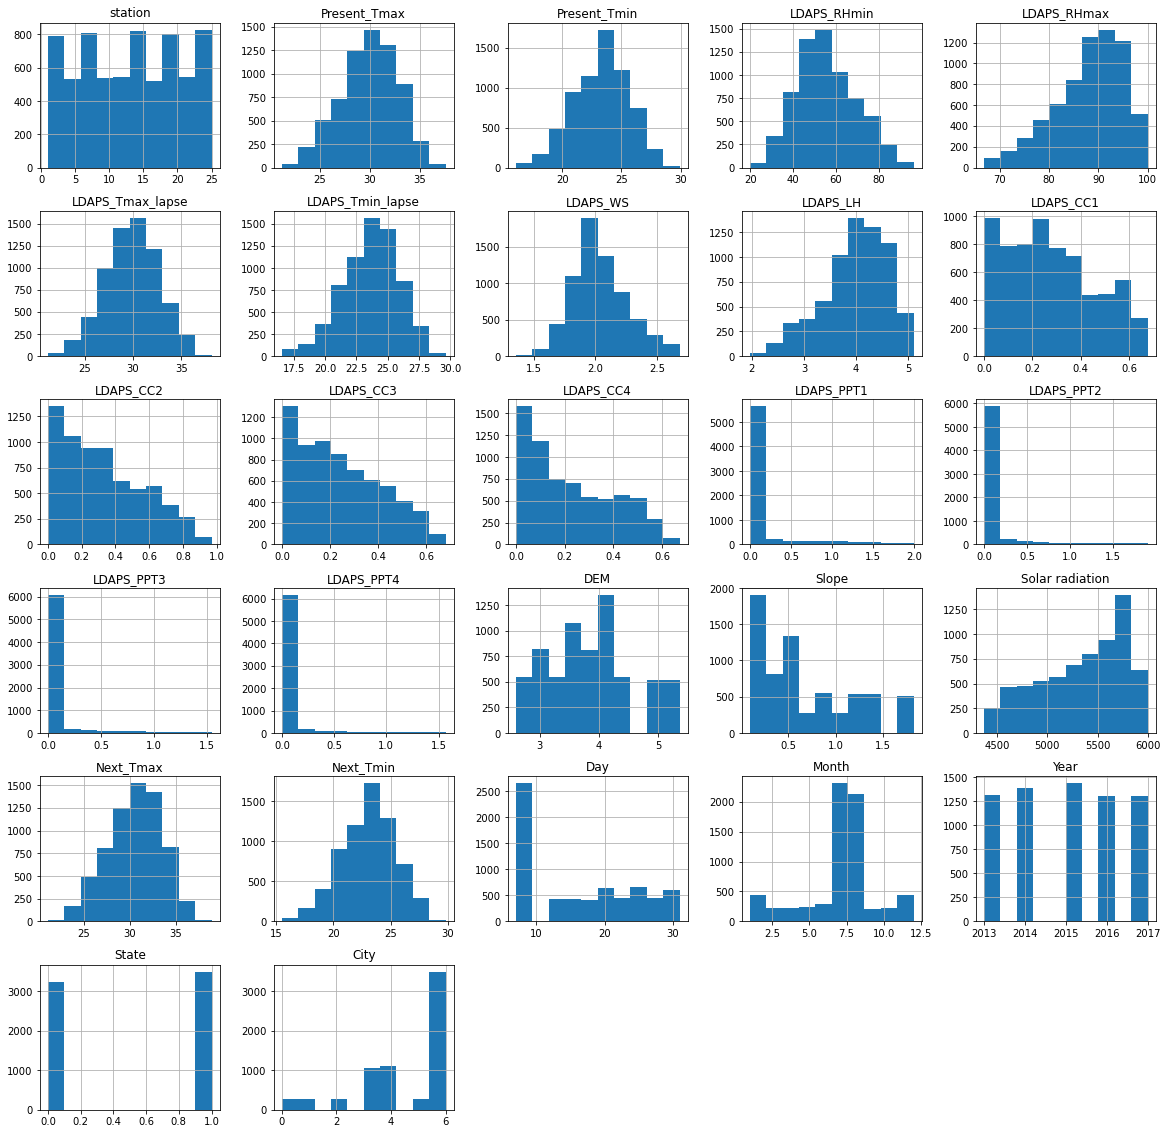

In [31]:
df.hist(figsize=(20,20))
plt.show()

Using the above histogram we are taking a look at the data points for all our columns that have been uniformed and listed as float values.

# Correlation using a Heatmap

- Positive correlation - A correlation of +1 indicates a perfect positive correlation, meaning that both variables move in the same direction together.
- Negative correlation - A correlation of –1 indicates a perfect negative correlation, meaning that as one variable goes up, the other goes down.

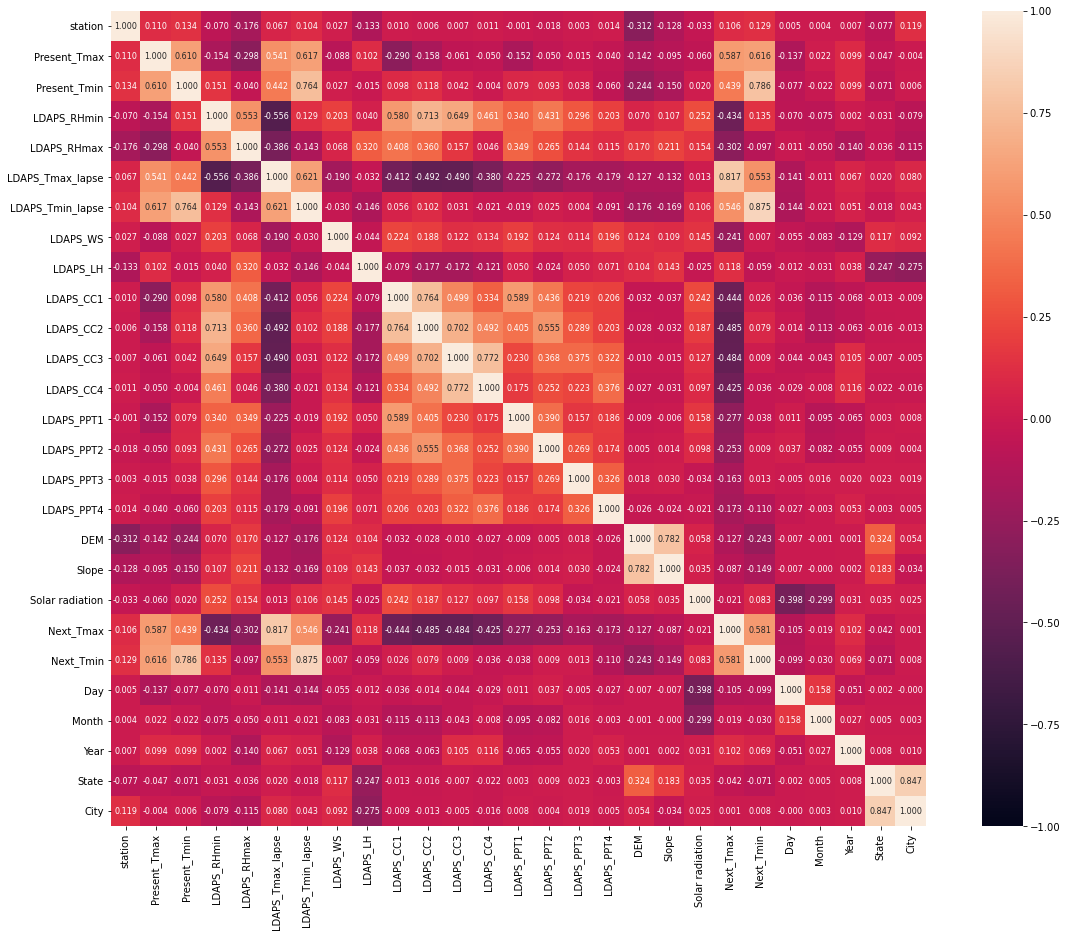

In [32]:
plt.figure(figsize=(20,15))
sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=True, square=True, fmt='0.3f', annot_kws={'size':8})
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

In the above heatmap we are not able to see the correlation details properly but we can make out from the colors that there are few columns which are multicollinear. However they seem to add weightage over the label predictions therefore we shall retain them all.

# Correlation Bar Plot comparing features with our label

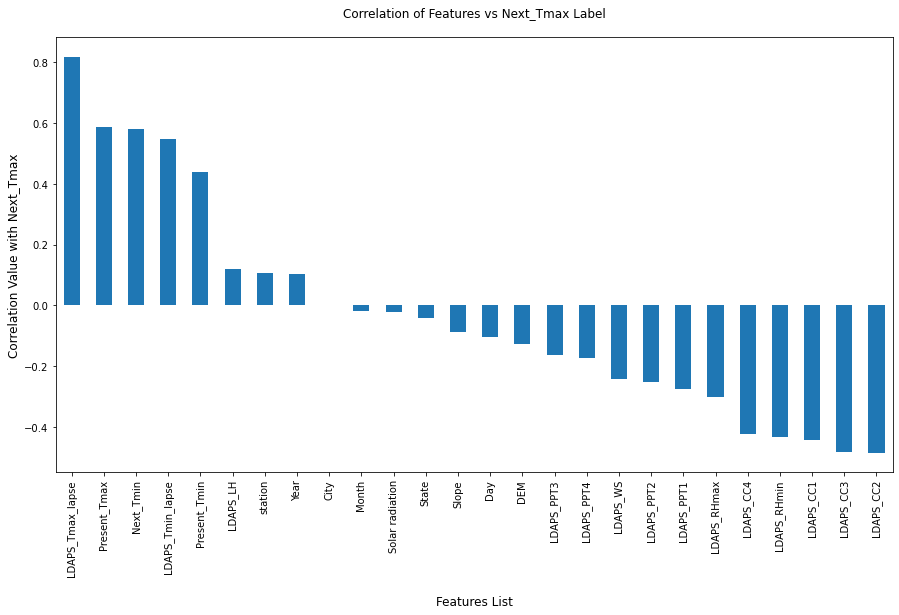

In [33]:
df_corr = df.corr()
plt.figure(figsize=(15,8))
df_corr[label_columns[0]].sort_values(ascending=False).drop(label_columns[0]).plot.bar()
plt.title("Correlation of Features vs Next_Tmax Label\n", fontsize=12)
plt.xlabel("\nFeatures List", fontsize=12)
plt.ylabel("Correlation Value with Next_Tmax", fontsize=12)
plt.show()

Since the heatmap was not able to give us a clearer picture on positive and negative correlation columns we have generated this bar plot and we see that less than half the columns in our dataset are positively correlated with our target label while all the remaining features are negatively correlated with our label column. This indicates that they are all required for the prediction of our regression temperature label "Next_Tmax"

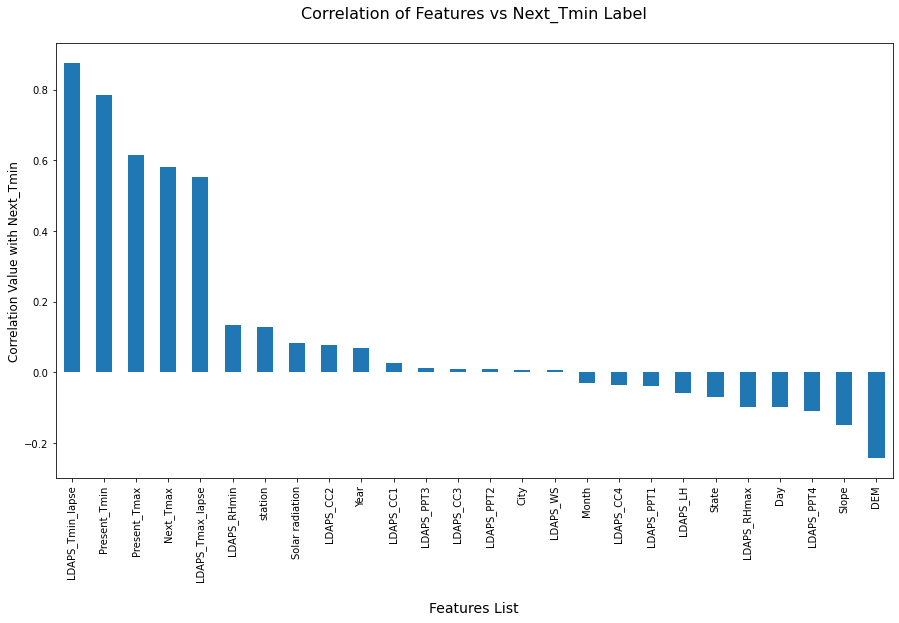

In [34]:
df_corr = df.corr()
plt.figure(figsize=(15,8))
df_corr[label_columns[1]].sort_values(ascending=False).drop(label_columns[1]).plot.bar()
plt.title("Correlation of Features vs Next_Tmin Label\n", fontsize=16)
plt.xlabel("\nFeatures List", fontsize=14)
plt.ylabel("Correlation Value with Next_Tmin", fontsize=12)
plt.show()

Since the heatmap was not able to give us a clearer picture on positive and negative correlation columns we have generated this bar plot and we see that more than half the columns in our dataset are positively correlated with our target label while all the remaining features are negatively correlated with our label column. This indicates that they are all required for the prediction of our regression temperature label "Next_Tmin"

In [35]:
df.dropna(inplace=True)

Making sure that there are no null values present in our dataframe.

# Splitting the dataset into 2 variables namely 'X' and 'Y' for feature and label

In [36]:
X = df[feature_columns]
Y = df[label_columns]

I have separated the dataset into features and labels where X represents all the feature columns and Y represents the regression target label columns.

# Feature Scaling

In [37]:
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
X.head() # Displaying all the features after applying scaling technique to avoid bias output

,station,Present_Tmax,Present_Tmin,LDAPS_RHmin,LDAPS_RHmax,LDAPS_Tmax_lapse,LDAPS_Tmin_lapse,LDAPS_WS,LDAPS_LH,LDAPS_CC1,...,LDAPS_PPT3,LDAPS_PPT4,DEM,Slope,Solar radiation,Day,Month,Year,State,City
0,-1.672567,-0.425700,-0.814500,0.196395,0.437853,-0.662880,-0.289974,0.092417,0.452470,-0.379706,...,-0.30398,-0.276791,2.091799,1.331482,1.543379,1.673912,-0.480146,-1.421373,0.963847,0.815920
1,-1.533807,0.690139,-0.727830,-0.236316,0.364545,-0.016965,0.171305,-0.612724,-0.012952,-0.417455,...,-0.30398,-0.276791,-0.026183,-0.501985,1.249793,1.673912,-0.480146,-1.421373,0.963847,0.815920
2,-1.395048,0.585529,0.008862,-0.494322,-0.585562,0.070512,0.409386,-0.320205,-1.474701,-0.490491,...,-0.30398,-0.276791,-0.422591,-0.859943,1.236117,1.673912,-0.480146,-1.421373,0.963847,0.815920
3,-1.256289,0.725009,0.052197,0.195247,1.206882,-0.070068,-0.146736,-0.641138,0.364021,-0.458616,...,-0.30398,-0.276791,0.002192,1.194627,1.220460,1.673912,-0.480146,-1.421373,0.963847,0.815920
4,-1.117529,0.515789,-0.597826,0.046081,0.300127,-0.284827,-0.074811,-0.583629,1.162615,-0.760531,...,-0.30398,-0.276791,-0.354858,-0.513383,1.226606,1.673912,-0.480146,-1.421373,-1.037509,-0.885969


I am using the `StandardScaler` method to normalize my feature values and ensure that my regression model does not have any kind of biasness towards a particular feature column value.

# Finding the best random state for building Regression Models

In [38]:
maxAccu=0
maxRS=0

for i in range(1, 1000):
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=i)
    lr=LinearRegression()
    lr.fit(X_train, Y_train)
    pred = lr.predict(X_test)
    r2 = r2_score(Y_test, pred)
    
    if r2>maxAccu:
        maxAccu=r2
        maxRS=i

print("Best R2 score is", maxAccu,"on Random State", maxRS)

Best R2 score is 0.8121520230318222 on Random State 43


Great so with the help of random state selection process we have found our lucky number to be 43 amongst 1-1000.

# Feature importance bar graph

In [39]:
rf=RandomForestRegressor()
rf.fit(X_train, Y_train)
importances = pd.DataFrame({'Features':X.columns, 'Importance':np.round(rf.feature_importances_,3)})
importances = importances.sort_values('Importance', ascending=False).set_index('Features')
importances

,Importance
Features,
LDAPS_Tmax_lapse,0.433
LDAPS_Tmin_lapse,0.242
Present_Tmax,0.060
Present_Tmin,0.033
LDAPS_CC4,0.026
LDAPS_CC1,0.025
LDAPS_CC2,0.025
LDAPS_CC3,0.022
LDAPS_WS,0.021


Here with the help of `RandomForestRegressor` we are able to list down the importance or priority given to a column as per it's involvement or weightage in predicting our label.

# Machine Learning Model for Regression with Evaluation Metrics

In [40]:
# Regression Model Function

def reg(model, X, Y):
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=43)
    
    # Training the model
    model.fit(X_train, Y_train)
    
    # Predicting Y_test
    pred = model.predict(X_test)
    
    # RMSE - a lower RMSE score is better than a higher one
    rmse = mean_squared_error(Y_test, pred, squared=False)
    print("RMSE Score is:", rmse)
    
    # R2 score
    r2 = r2_score(Y_test, pred, multioutput='variance_weighted')*100
    print("R2 Score is:", r2)
    
    # Cross Validation Score
    cv_score = (cross_val_score(model, X, Y, cv=5).mean())*100
    print("Cross Validation Score:", cv_score)
    
    # Result of r2 score minus cv score
    result = r2 - cv_score
    print("R2 Score - Cross Validation Score is", result)

I have built a regression function that splits the training and testing features and labels, then trains the model, predicts the label, calculates the RMSE score, generates the R2 score, calculates the Cross Validation score and finally finds the difference between the R2 score and Cross Validation score.

In [41]:
# Linear Regression Model

model=LinearRegression()
reg(model, X, Y)

RMSE Score is: 1.1651205867934091
R2 Score is: 80.60747763604735
Cross Validation Score: 71.49561139897992
R2 Score - Cross Validation Score is 9.111866237067431


Created the linear regression model and checked for all it's evaluation metrics as well.

In [42]:
# Ridge Regression

model=Ridge(alpha=1e-2, normalize=True)
reg(model, X, Y)

RMSE Score is: 1.1654077789590633
R2 Score is: 80.59847823134517
Cross Validation Score: 71.69253601663934
R2 Score - Cross Validation Score is 8.905942214705831


Created the ridge regression model and checked for all it's evaluation metrics as well.

In [43]:
# Lasso Regression

model=Lasso(alpha=1e-2, normalize=True, max_iter=1e5)
reg(model, X, Y)

RMSE Score is: 1.5317823484827837
R2 Score is: 66.78928525919407
Cross Validation Score: 60.27056929222759
R2 Score - Cross Validation Score is 6.518715966966482


Created the lasso regression model and checked for all it's evaluation metrics as well.

In [44]:
# Decision Tree Regressor

model=DecisionTreeRegressor(criterion="poisson", random_state=111)
reg(model, X, Y)

RMSE Score is: 1.8714450244528524
R2 Score is: 50.903536337382896
Cross Validation Score: 24.549720914698167
R2 Score - Cross Validation Score is 26.35381542268473


Created the decision tree regression model and checked for all it's evaluation metrics as well.

In [45]:
# Random Forest Regressor

model=RandomForestRegressor(max_depth=2, max_features="sqrt")
reg(model, X, Y)

RMSE Score is: 1.7467654871224336
R2 Score is: 57.168548257482485
Cross Validation Score: 45.79961079339945
R2 Score - Cross Validation Score is 11.368937464083032


Created the random forest regression model and checked for all it's evaluation metrics as well.

In [46]:
# K Neighbors Regressor

model=KNeighborsRegressor(n_neighbors=2, algorithm='kd_tree')
reg(model, X, Y)

RMSE Score is: 1.054645786820847
R2 Score is: 84.50299199271053
Cross Validation Score: 43.76403203594178
R2 Score - Cross Validation Score is 40.73895995676875


Created the k neighbors regression model and checked for all it's evaluation metrics as well.

In [47]:
# Extra Trees Regressor

model=ExtraTreesRegressor(n_estimators=200, max_features='sqrt', n_jobs=6)
reg(model, X, Y)

RMSE Score is: 0.7622282704429526
R2 Score is: 91.89106004119405
Cross Validation Score: 68.8991048762685
R2 Score - Cross Validation Score is 22.991955164925557


Created the extra trees regression model and checked for all it's evaluation metrics as well.

In [48]:
# Gradient Boosting Regressor

gbr=GradientBoostingRegressor()
model=MultiOutputRegressor(estimator=gbr)
reg(model, X, Y)

RMSE Score is: 0.9410216146444064
R2 Score is: 87.39936624669757
Cross Validation Score: 73.24627121523386
R2 Score - Cross Validation Score is 14.153095031463707


Created the gradient boosting regression model and checked for all it's evaluation metrics as well.

In [49]:
# Bagging Regressor

model=BaggingRegressor()
reg(model, X, Y)

RMSE Score is: 0.9184141255428211
R2 Score is: 88.1633954165538
Cross Validation Score: 67.62670059913629
R2 Score - Cross Validation Score is 20.536694817417512


Created the bagging regression model and checked for all it's evaluation metrics as well.

In [50]:
# Linear SVR

lsvr=LinearSVR()
model=MultiOutputRegressor(lsvr)
reg(model, X, Y)

RMSE Score is: 1.1748062087925828
R2 Score is: 80.26275182907348
Cross Validation Score: 71.8637295444519
R2 Score - Cross Validation Score is 8.39902228462158


Created the linear SVR regression model and checked for all it's evaluation metrics as well.

# Hyper parameter tuning on the best Regression ML Model

In [51]:
# Choosing ExtraTrees Regressor Model

fmod_param = {'max_features' : ['auto', 'sqrt', 'log2'],
              'n_jobs' : [1, 4, 6],
              'random_state' : [10, 42, 43],
              'n_estimators' : [100, 200, 300]}

In [52]:
GSCV = GridSearchCV(ExtraTreesRegressor(), fmod_param, cv=5)

In [53]:
GSCV.fit(X_train,Y_train)

GridSearchCV(cv=5, estimator=ExtraTreesRegressor(),
             param_grid={'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': [100, 200, 300], 'n_jobs': [1, 4, 6],
                         'random_state': [10, 42, 43]})

In [54]:
GSCV.best_params_

{'max_features': 'auto', 'n_estimators': 300, 'n_jobs': 6, 'random_state': 43}

In the above cell we have received the entire list of parameters after training our model by giving it different inputs and choosing the best one out of them.

In [55]:
Final_Model = ExtraTreesRegressor(max_features = 'auto', n_estimators = 300, n_jobs = 6, random_state = 43)
Regressor = Final_Model.fit(X_train, Y_train)
fmod_pred = Final_Model.predict(X_test)
fmod_r2 = r2_score(Y_test, fmod_pred)*100
print("R2 score for the Best Model is:", fmod_r2)

R2 score for the Best Model is: 91.92592978734852


Built our final model using the hyper tuned parameters

# Saving the best Regression ML model

In [56]:
filename = "FinalModel_E07.pkl"
joblib.dump(Final_Model, filename)

['FinalModel_E07.pkl']

Saved my best Regression model using the joblib library.